In [1]:
!pip install -q pandas scikit-learn matplotlib

import os, time, pathlib
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn


In [2]:
import shutil
from google.colab import drive
drive.mount("/content/gdrive")
# Change the code below if the path to the dataset is different for you.
shutil.unpack_archive("/content/gdrive/MyDrive/ddos_dataset.zip", "/tmp/")

Mounted at /content/gdrive


In [11]:
# Sadece Features (10 feature)
csv_path = "/tmp/dataset_sdn.csv"   # kendi yolunu yaz
df = pd.read_csv(csv_path, low_memory=False)
print(df.shape)
display(df.head())

(104345, 23)


,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,...,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
0,11425,1,10.0.0.1,10.0.0.8,45304,48294064,100,716000000,1.010000e+11,3,...,451,0,UDP,3,143928631,3917,0,0.0,0.0,0
1,11605,1,10.0.0.1,10.0.0.8,126395,134737070,280,734000000,2.810000e+11,2,...,451,0,UDP,4,3842,3520,0,0.0,0.0,0
2,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,1,3795,1242,0,0.0,0.0,0
3,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,2,3688,1492,0,0.0,0.0,0
4,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,3,3413,3665,0,0.0,0.0,0


In [12]:
SELECTED_FEATURES = [
    'dt','pktcount','bytecount','dur','tot_dur',
    'packetins','pktperflow','byteperflow','pktrate','tx_bytes'
]

df = df[SELECTED_FEATURES].dropna().reset_index(drop=True)
print("Using:", df.columns.tolist())

# Scale 0–1
scaler = MinMaxScaler()
X = scaler.fit_transform(df.values)
FEATURE_DIM = X.shape[1]
print("Feature dim:", FEATURE_DIM)

# Train/val split
X_train, X_val = train_test_split(X, test_size=0.1, random_state=42)


Using: ['dt', 'pktcount', 'bytecount', 'dur', 'tot_dur', 'packetins', 'pktperflow', 'byteperflow', 'pktrate', 'tx_bytes']
Feature dim: 10


In [20]:
# Generator & Discriminator (Vanilla GAN)


import torch
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Z_DIM = 64
HIDDEN = 128
LR = 2e-4
BETAS = (0.5, 0.999)
BATCH_SIZE = 256
EPOCHS = 200

class Generator(nn.Module):
    def __init__(self, z_dim, out_dim, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, hidden),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden, hidden),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden, out_dim),
            nn.Sigmoid()
        )
    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, in_dim, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden, hidden),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

G = Generator(Z_DIM, FEATURE_DIM, HIDDEN).to(device)
D = Discriminator(FEATURE_DIM, HIDDEN).to(device)

optG = torch.optim.Adam(G.parameters(), lr=LR, betas=BETAS)
optD = torch.optim.Adam(D.parameters(), lr=LR, betas=BETAS)

criterion = nn.BCELoss()

train_loader = torch.utils.data.DataLoader(
    torch.tensor(X_train, dtype=torch.float32),
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)


In [24]:
history_D = []
history_G = []

for epoch in range(1, EPOCHS + 1):

    D_loss_epoch = 0.0
    G_loss_epoch = 0.0
    batch_count = 0

    for real in train_loader:
        real = real.to(device)
        B = real.size(0)
        batch_count += 1

        # ---------------------- Train Discriminator ----------------------
        D.zero_grad()

        real_target = torch.full((B, 1), 0.9, device=device)  # label smoothing
        fake_target = torch.zeros((B, 1), device=device)

        out_real = D(real)
        loss_real = criterion(out_real, real_target)

        z = torch.randn(B, Z_DIM, device=device)
        fake = G(z).detach()
        out_fake = D(fake)
        loss_fake = criterion(out_fake, fake_target)

        loss_D = (loss_real + loss_fake) / 2
        loss_D.backward()
        optD.step()

        # ---------------------- Train Generator ----------------------
        G.zero_grad()
        z2 = torch.randn(B, Z_DIM, device=device)
        gen = G(z2)
        pred = D(gen)

        loss_G = criterion(pred, real_target)
        loss_G.backward()
        optG.step()

        # accumulate losses
        D_loss_epoch += loss_D.item()
        G_loss_epoch += loss_G.item()

    # ----------- Epoch average loss -----------
    avg_D = D_loss_epoch / batch_count
    avg_G = G_loss_epoch / batch_count

    history_D.append(avg_D)
    history_G.append(avg_G)

    if epoch % 5 == 0:
        print(f"Epoch {epoch}/{EPOCHS}  D={avg_D:.4f}  G={avg_G:.4f}")


Epoch 5/200  D=0.6191  G=0.9072
Epoch 10/200  D=0.6175  G=0.9122
Epoch 15/200  D=0.6132  G=0.9197
Epoch 20/200  D=0.6111  G=0.9263
Epoch 25/200  D=0.6092  G=0.9317
Epoch 30/200  D=0.6068  G=0.9396
Epoch 35/200  D=0.6058  G=0.9401
Epoch 40/200  D=0.6032  G=0.9450
Epoch 45/200  D=0.6025  G=0.9491
Epoch 50/200  D=0.5996  G=0.9546
Epoch 55/200  D=0.5978  G=0.9630
Epoch 60/200  D=0.5963  G=0.9663
Epoch 65/200  D=0.5965  G=0.9690
Epoch 70/200  D=0.5946  G=0.9762
Epoch 75/200  D=0.5930  G=0.9788
Epoch 80/200  D=0.5917  G=0.9813
Epoch 85/200  D=0.5910  G=0.9830
Epoch 90/200  D=0.5888  G=0.9898
Epoch 95/200  D=0.5882  G=0.9931
Epoch 100/200  D=0.5869  G=0.9966
Epoch 105/200  D=0.5863  G=0.9972
Epoch 110/200  D=0.5841  G=1.0029
Epoch 115/200  D=0.5840  G=1.0050
Epoch 120/200  D=0.5840  G=1.0060
Epoch 125/200  D=0.5835  G=1.0089
Epoch 130/200  D=0.5811  G=1.0134
Epoch 135/200  D=0.5815  G=1.0158
Epoch 140/200  D=0.5798  G=1.0207
Epoch 145/200  D=0.5794  G=1.0254
Epoch 150/200  D=0.5807  G=1.0255


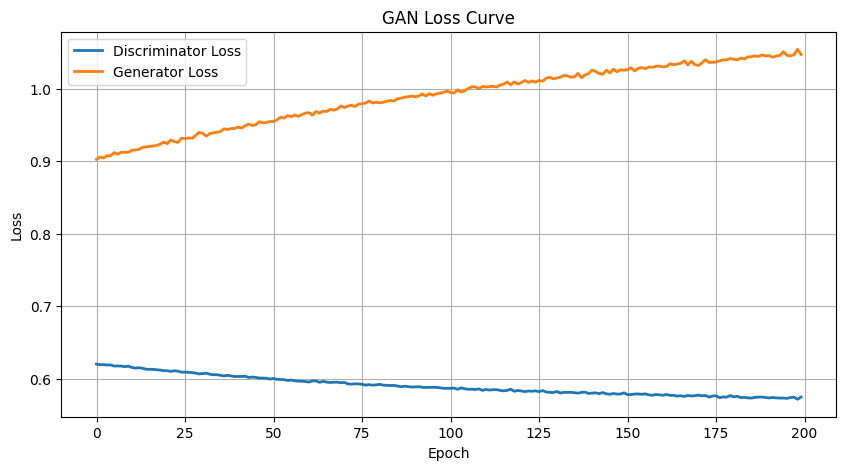

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(history_D, label="Discriminator Loss", linewidth=2)
plt.plot(history_G, label="Generator Loss", linewidth=2)
plt.title("GAN Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [26]:
# Synthetic Data Production


def generate_synthetic(n=5000):
    G.eval()
    with torch.no_grad():
        z = torch.randn(n, Z_DIM, device=device)
        syn = G(z).cpu().numpy()
        syn_inv = scaler.inverse_transform(syn)
        return syn_inv

synthetic = generate_synthetic(5000)
synthetic_df = pd.DataFrame(synthetic, columns=SELECTED_FEATURES)
print("Synthetic shape:", synthetic_df.shape)



Synthetic shape: (5000, 10)


In [27]:
synthetic_df.to_csv("synthetic_gan.csv", index=False)
print("Saved synthetic_gan.csv")

Saved synthetic_gan.csv


In [28]:
# Feature Similarity Metrics

# (KS-stat, KS-pvalue, KL divergence, Wasserstein)

from scipy.stats import ks_2samp, entropy, wasserstein_distance

real_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
syn_norm = pd.DataFrame(scaler.transform(synthetic_df), columns=df.columns)

metrics = []
for col in SELECTED_FEATURES:
    real_col = real_norm[col]
    syn_col  = syn_norm[col]

    ks_stat, ks_p = ks_2samp(real_col, syn_col)

    hist_real = np.histogram(real_col, bins=50, density=True)[0] + 1e-6
    hist_syn  = np.histogram(syn_col,  bins=50, density=True)[0] + 1e-6
    kl = entropy(hist_real, hist_syn)

    w = wasserstein_distance(real_col, syn_col)

    metrics.append({
        "Feature": col,
        "KS_stat": round(ks_stat,4),
        "KS_p": round(ks_p,4),
        "KL_divergence": round(kl,4),
        "Wasserstein": round(w,4)
    })

metrics_df = pd.DataFrame(metrics)
print(metrics_df.sort_values("KS_stat"))


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


       Feature  KS_stat  KS_p  KL_divergence  Wasserstein
3          dur   0.0942   0.0         0.1195       0.0283
0           dt   0.0962   0.0         0.3035       0.0222
4      tot_dur   0.1011   0.0         0.1238       0.0288
5    packetins   0.1459   0.0         0.5304       0.0662
8      pktrate   0.1928   0.0         2.5289       0.0077
9     tx_bytes   0.1976   0.0         0.1356       0.0084
1     pktcount   0.2220   0.0         0.3314       0.0444
2    bytecount   0.2445   0.0         0.1196       0.0320
6   pktperflow   0.3258   0.0         2.8899       0.0073
7  byteperflow   0.3295   0.0         1.9982       0.0116


In [29]:
# Machine Learning Utility

# TSTR → Train Synthetic, Test Real
# TRTS → Train Real, Test Synthetic


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# Add fake labels via clustering (unsupervised)
from sklearn.cluster import KMeans

kmeans_real = KMeans(n_clusters=2, random_state=42).fit(real_norm)
kmeans_syn = KMeans(n_clusters=2, random_state=42).fit(syn_norm)

real_y = kmeans_real.labels_
syn_y  = kmeans_syn.labels_

X_real = real_norm.values
X_syn  = syn_norm.values

# --------- TSTR ----------
clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_syn, syn_y)
pred_real = clf.predict(X_real)

print("\n=== TSTR (Train Synthetic → Test Real) ===")
print("Accuracy:", accuracy_score(real_y, pred_real))
print("F1:", f1_score(real_y, pred_real))

# --------- TRTS ----------
clf2 = RandomForestClassifier(n_estimators=150, random_state=42)
clf2.fit(X_real, real_y)
pred_syn = clf2.predict(X_syn)

print("\n=== TRTS (Train Real → Test Synthetic) ===")
print("Accuracy:", accuracy_score(syn_y, pred_syn))
print("F1:", f1_score(syn_y, pred_syn))



=== TSTR (Train Synthetic → Test Real) ===
Accuracy: 0.01925343811394892
F1: 0.029916960527812536

=== TRTS (Train Real → Test Synthetic) ===
Accuracy: 0.0208
F1: 0.0384917517674784
